# Materials Data Modeling

*Author*: Zachary del Rosario (zdelrosario@olin.edu)

---

This is a quick tour of using [Grama](https://github.com/zdelrosario/py_grama) to support materials informatics studies. I illustrate how to featurize materials data using the Matminer toolkit[2], visualize high-dimensional data to look for clusters[3], and fit a predictive model for materials properties[4].


In [1]:
# Core informatics libraries
import grama as gr
import plotnine as gg
import pandas as pd

# Auxillary functions
from grama.tran import tf_feat_composition # Chemical composition featurizer
from grama.tran import tf_tsne             # t-SNE dimension reduction
from grama.fit import ft_rf                # Random forest regressor model

# For downloading data
import os
import requests

X = gr.Intention()

## Obtain data

First we obtain materials data to study. The following code downloads a local copy of the open MPEA dataset[1]. These data represent high-entropy alloys reported in the literature, and contain chemical formulae and various physical properties.


In [2]:
# Filename for local data
filename_data = "./mpea.csv"

if not os.path.exists(filename_data):
    # Make request for data
    url_data = "https://docs.google.com/spreadsheets/u/1/d/1MsF4_jhWtEuZSvWfXLDHWEqLMScGCVXYWtqHW9Y7Yt0/export?format=csv"
    r = requests.get(url_data, allow_redirects=True)
    open(filename_data, 'wb').write(r.content)
    print("   MPEA data downloaded from public Google sheet")
else:
    # Note data already exists
    print("    MPEA data loaded locally")
    
# Read the data into memory
df_mpea = pd.read_csv(filename_data)

# Check basic facts
print(df_mpea.shape)
df_mpea.head()

    MPEA data loaded locally
(1653, 20)


,IDENTIFIER: Reference ID,FORMULA,PROPERTY: Microstructure,PROPERTY: Processing method,PROPERTY: grain size ($\mu$m),PROPERTY: ROM Density (g/cm$^3$),PROPERTY: Exp. Density (g/cm$^3$),PROPERTY: HV,PROPERTY: Type of test,PROPERTY: Test temperature ($^\circ$C),PROPERTY: YS (MPa),PROPERTY: UTS (MPa),PROPERTY: Elongation (%),PROPERTY: Elongation plastic (%),PROPERTY: Young modulus (GPa),PROPERTY: O content (wppm),PROPERTY: N content (wppm),PROPERTY: C content (wppm),REFERENCE: doi,REFERENCE: year
0,146,Cr1 Mo1 Nb1 Ta1 V1 W1,NaN,POWDER,5.01,NaN,NaN,991.3,C,25.0,3410.0,NaN,2.0,NaN,NaN,7946.0,NaN,NaN,10.1016/j.jallcom.2018.11.318,2018
1,146,Cr1 Mo1 Nb1 Ta1 V1 W1,NaN,POWDER,10.80,NaN,NaN,988.3,C,25.0,3338.0,NaN,1.9,NaN,NaN,7946.0,NaN,NaN,10.1016/j.jallcom.2018.11.318,2018
2,137,Co1 Cr1 Fe1 Ni1,FCC,CAST,NaN,NaN,NaN,94.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.1016/j.matdes.2019.107698,2019
3,19,Al1 Cr1 Fe1 Mo1 Ni1,B2+Sec.,CAST,NaN,7.2,NaN,905.0,NaN,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.1016/j.jallcom.2013.03.253,2013
4,155,Al1 Co0.426 Cr0.383 Cu0.106 Fe0.106 Ni0.106,NaN,NaN,NaN,NaN,NaN,883.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.1016/j.actamat.2019.03.010,2019


## Featurize

Grama ships with a convenient interface to the Matminer[2] package, which enables quick [*featurization*](https://en.wikipedia.org/wiki/Feature_engineering) of materials data. The code below filters out valid observations on a desired output property (yield strength) and temperature, then converts the chemical formulae above into a little over 100 physically-relevant chemical descriptors for subsequent informatics study.


In [3]:
## Select output property to model
out = "PROPERTY: YS (MPa)"

df_working = (
    df_mpea
    >> gr.tf_dropna(subset=[out, "PROPERTY: Test temperature ($^\circ$C)"])
    >> tf_feat_composition() # Grama utility for Matminer featurization
)

print(df_working.shape)


(1144, 152)


**Observations**:

- We have `1144 / 1653` valid observations on the yield strength.

## Visualize feature space

Next we'll use the features generated above to visualize the available data. The following code selects only those features we'll use for exploration and modeling: The Matminer-derived features, and the experimental temperature.


In [4]:
# Select desired features
var_feat = (
    df_working
    >> gr.tf_select(gr.contains("Magpie"), gr.contains("temperature"))
).columns
print(var_feat)


Index(['MagpieData minimum Number', 'MagpieData maximum Number',
       'MagpieData range Number', 'MagpieData mean Number',
       'MagpieData avg_dev Number', 'MagpieData mode Number',
       'MagpieData minimum MendeleevNumber',
       'MagpieData maximum MendeleevNumber',
       'MagpieData range MendeleevNumber', 'MagpieData mean MendeleevNumber',
       ...
       'MagpieData mean GSmagmom', 'MagpieData avg_dev GSmagmom',
       'MagpieData mode GSmagmom', 'MagpieData minimum SpaceGroupNumber',
       'MagpieData maximum SpaceGroupNumber',
       'MagpieData range SpaceGroupNumber', 'MagpieData mean SpaceGroupNumber',
       'MagpieData avg_dev SpaceGroupNumber',
       'MagpieData mode SpaceGroupNumber',
       'PROPERTY: Test temperature ($^\circ$C)'],
      dtype='object', length=133)


We have `133` features in total; reduce dimensionality to just two dimensions using [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)[3].


In [5]:
df_tsne = (
    df_working
    >> gr.tf_select(var_feat)
    >> tf_tsne(append=True)
)


Visualize the data using the t-SNE reduction; are there clusters in feature space?


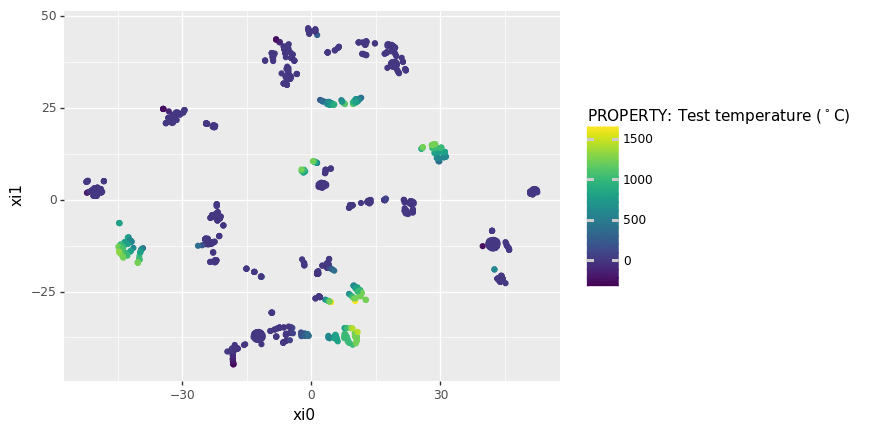

<ggplot: (8772509474189)>

In [6]:
(
    gg.ggplot(df_tsne, gg.aes("xi0", "xi1", color="PROPERTY: Test temperature ($^\circ$C)"))
    + gg.geom_point()
)


**Observations**:

- The observations do seem to cluster. Follow-up studies could investigate whether similar elements account for cluster behavior.
- Test temperatures tend to be low over the dataset.
- Wide ranges of test temperature tend to cluster together; these are probably the result of single studies that tested chemically-similar specimens at different temperatures.

## Predictive Modeling

Finally we'll use a random forest[4] model to predict the yield strength from the chemical features.

The following code defines a "model plan": a selection of features to use for fitting (`var`) and a target property to model (`out`).

In [7]:
# Define model architecture to fit
ft_base = ft_rf(var=var_feat, out=[out])

The following code fits the model to the full working dataset (to assess baseline accuracy), and performs k-fold cross validation to estimate prediction error.


In [8]:
# Fit and assess baseline model
md_base = (
    df_working
    >> ft_base()
)

df_base = (
    md_base
    >> gr.ev_df(df=df_working)
    >> gr.tf_rename(pred=X[out])
    >> gr.tf_bind_cols(df_working[[out]])
)

ndme_base = (
    df_base 
    >> gr.tf_summarize(ndme=gr.ndme(X.pred, X[out]))
).ndme.values[0]

# Estimate test error with k-fold CV
df_kfold = (
    df_base
    >> gr.tf_kfolds(ft=ft_base, k=5, summaries=dict(ndme=gr.ndme))
)

... provided columns intersect model output.
eval_df() is dropping {'PROPERTY: YS (MPa)'}


First let's assess the numerical error metrics, quantified in terms of *non-dimensional model error* (NDME); zero is the ideal, and one is a highly inaccurate model.


In [9]:
print("Baseline error {0:4.3f}\n".format(ndme_base))
df_kfold.describe()

Baseline error 0.321



,ndme_PROPERTY: YS (MPa),_kfold
count,5.000000,5.000000
mean,0.497470,2.000000
std,0.033509,1.581139
min,0.452164,0.000000
25%,0.485245,1.000000
50%,0.494623,2.000000
75%,0.512524,3.000000
max,0.542797,4.000000


**Observations**:

- Baseline (training) error is fairly low, around `ndme = 0.3`.
- Test error is likely to be much higher, around `ndme = 0.5`.

Finally, let's construct a predicted vs actual plot and overlay temperature; is there any relation between accuracy and experiment temperature?

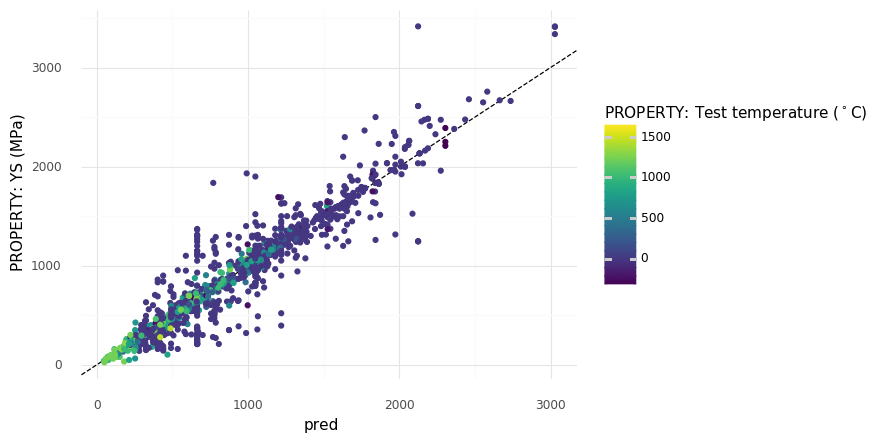

<ggplot: (8772509714125)>

In [10]:
(
    gg.ggplot(df_base, gg.aes("pred", out, color="PROPERTY: Test temperature ($^\circ$C)"))
    + gg.geom_abline(intercept=0, slope=1, linetype="dashed")
    + gg.geom_point()
    + gg.theme_minimal()
)

**Observations**:

- Higher-temperature tests correspond to lower yield strength cases.
- The higher-temperature cases do not seem to be the cases with the highest error.
- There are a strange "vertical stripes" of cases with different realized yield strength, but the same prediction. Are these repeat observations on the same formula?

This was just a taste of the materials informatics questions one could probe with Grama!

# References

---

[1] Borg, Christopher; Frey, Carolina; Moh, Jasper; Miracle, Daniel; Saal, James E; Meredig, Bryce; et al. (2020): Expanded dataset of mechanical properties and observed phases of multi-principal element alloys. figshare. Dataset. https://doi.org/10.6084/m9.figshare.12642953.v2

[1] Ward, L., Dunn, A., Faghaninia, A., Zimmermann, N. E. R., Bajaj, S., Wang, Q.,
Montoya, J. H., Chen, J., Bystrom, K., Dylla, M., Chard, K., Asta, M., Persson,
K., Snyder, G. J., Foster, I., Jain, A., Matminer: An open source toolkit for
materials data mining. Comput. Mater. Sci. 152, 60-69 (2018).

[2] L.J.P. van der Maaten and G.E. Hinton. Visualizing High-Dimensional Data Using t-SNE. Journal of Machine Learning Research 9(Nov):2579-2605, 2008.

[3] sklearn, [Random forest regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)
